In [615]:
library(corrgram)  # for correlation plot
library(ggplot2)   #for visualization
library(dplyr)     
library(lubridate) #for date time extraction

In [616]:
rm(list = ls())

In [617]:
df=read.csv("../input/akshay1/train_cab.csv")
test1=read.csv("../input/akshay2/test.csv")

In [618]:
df$fare_amount=as.numeric(as.character(df$fare_amount))

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [619]:
lapply(df,function(x) { length(which(is.na(x)))})

$fare_amount
[1] 25

$pickup_datetime
[1] 0

$pickup_longitude
[1] 0

$pickup_latitude
[1] 0

$dropoff_longitude
[1] 0

$dropoff_latitude
[1] 0

$passenger_count
[1] 55

there are 80 null values. we will remove them as they are less compared to the size of the dataset.

In [620]:
df=na.omit(df)

In [621]:
head(df)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4.5,2009-06-15 17:26:21 UTC,-73.84431,40.72132,-73.84161,40.71228,1
2,16.9,2010-01-05 16:52:16 UTC,-74.01605,40.71130,-73.97927,40.78200,1
3,5.7,2011-08-18 00:35:00 UTC,-73.98274,40.76127,-73.99124,40.75056,2
4,7.7,2012-04-21 04:30:42 UTC,-73.98713,40.73314,-73.99157,40.75809,1
5,5.3,2010-03-09 07:51:00 UTC,-73.96810,40.76801,-73.95665,40.78376,1
6,12.1,2011-01-06 09:50:45 UTC,-74.00096,40.73163,-73.97289,40.75823,1


In [622]:
as.data.frame(table(df$passenger_count))

Var1,Freq
<fct>,<int>
0,57
0.12,1
1,11242
1.3,1
2,2319
3,675
4,328
5,1044
6,301


as we can see there are many mistakes here in the passenger count column. we will remove them.

In [623]:
df=subset(df,(df$passenger_count <= 10) & (df$passenger_count != 1.30) & (df$passenger_count != 0.12))
test1=subset(test1,(test1$passenger_count <= 10) & (test1$passenger_count != 1.30) & (test1$passenger_count != 0.12))

**The dataset is of cab rides in new york. we will remove all the observations which are outside of new york as they are outliers for our dataset.**

In [624]:
 df = subset(df,(-76 <= df$pickup_longitude) & (df$pickup_longitude <= -72))
    df = subset(df,(-76 <= df$dropoff_longitude) & (df$dropoff_longitude <= -72))
    df = subset(df,(38 <= df$pickup_latitude) & (df$pickup_latitude <= 42))
    df = subset(df,(38 <= df$dropoff_latitude) & (df$dropoff_latitude <= 42))
    
    df = subset(df,(df$dropoff_longitude != df$pickup_longitude))
    df = subset(df,(df$dropoff_latitude != df$pickup_latitude))
    
    
   test1 = subset(test1,(-76 <= test1$pickup_longitude) & (test1$pickup_longitude <= -72))
   test1 = subset(test1,(-76 <= test1$dropoff_longitude) & (test1$dropoff_longitude <= -72))
    test1 = subset(test1,(38 <= test1$pickup_latitude) & (test1$pickup_latitude <= 42))
    test1 = subset(test1,(38 <= test1$dropoff_latitude) & (test1$dropoff_latitude <= 42))
    
    test1 = subset(test1,(test1$dropoff_longitude != test1$pickup_longitude))
    test1 = subset(test1,(test1$dropoff_latitude != test1$pickup_latitude))

In [625]:
df=subset(df,df$pickup_datetime !='43')

In [626]:
df$pickup_datetime <- ymd_hms(df$pickup_datetime)
test1$pickup_datetime <- ymd_hms(test1$pickup_datetime)   #conversion into datetime format.

**we will extract day,month,year,weekday,hour values from the date time column to make things easy for us.**

In [628]:
df$date <- as.Date( df$pickup_datetime)
df$year <- year(df$date)
df$month <- month(df$date)
df$day <- day(df$date)
df$weekday <- wday(df$date, label = FALSE)
df$hour <- hour(df$pickup_datetime)
                   
test1$date <- as.Date(test1$pickup_datetime)
test1$year <- year(test1$date)
test1$month <- month(test1$date)
test1$day <- day(test1$date)
test1$weekday <- wday(test1$date,label=FALSE)
test1$hour <- hour(test1$pickup_datetime)

**we can now delete the datetime column from our dataset.**

In [629]:
df=subset(df,select=-c(pickup_datetime,date))
test1=subset(test1,select=-c(pickup_datetime,date))

**there are some fares which are negative.as it is practically impossible we will remove them.**

In [630]:
df=subset(df,df$fare_amount >= 0)

**we will create a function which will tell whether the ride happened at night or late night.**

In [631]:
late_night =function(row){
    ifelse(((row['hour'] <= 6) | (row['hour'] >= 20)),as.numeric("1"),as.numeric("0"))
}

night =function(row){
    ifelse(((row['hour'] <= 20) & (row['hour'] >= 16) & (row['weekday'] < 5)),as.numeric("1"),as.numeric("0"))
}
    

In [632]:
df$night=night(df)
df$late_night=late_night(df)

test1$night=night(test1)
test1$late_night=late_night(test1)
        

**there are some fares which are greater than 250 dollars. as it is practically impossible ,we will remove them.

In [633]:
df=subset(df,df$fare_amount <=250)

In [634]:
nrow(df)

[1] 15464

**we will create a function which will tell us about the distance travelled in miles.**

In [635]:
distance = function(lat1, lat2, lon1,lon2){
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return(0.6213712 * 12742 * sin(sqrt(a)))
}

In [636]:
df["trip_distance"]=distance(df['pickup_latitude'],df['dropoff_latitude'],df['pickup_longitude'],df['dropoff_longitude'])
test1["trip_distance"]=distance(test1['pickup_latitude'],test1['dropoff_latitude'],test1['pickup_longitude'],test1['dropoff_longitude'])

# Exploratory data analysis.
we will do some analysis here and try to find insights.

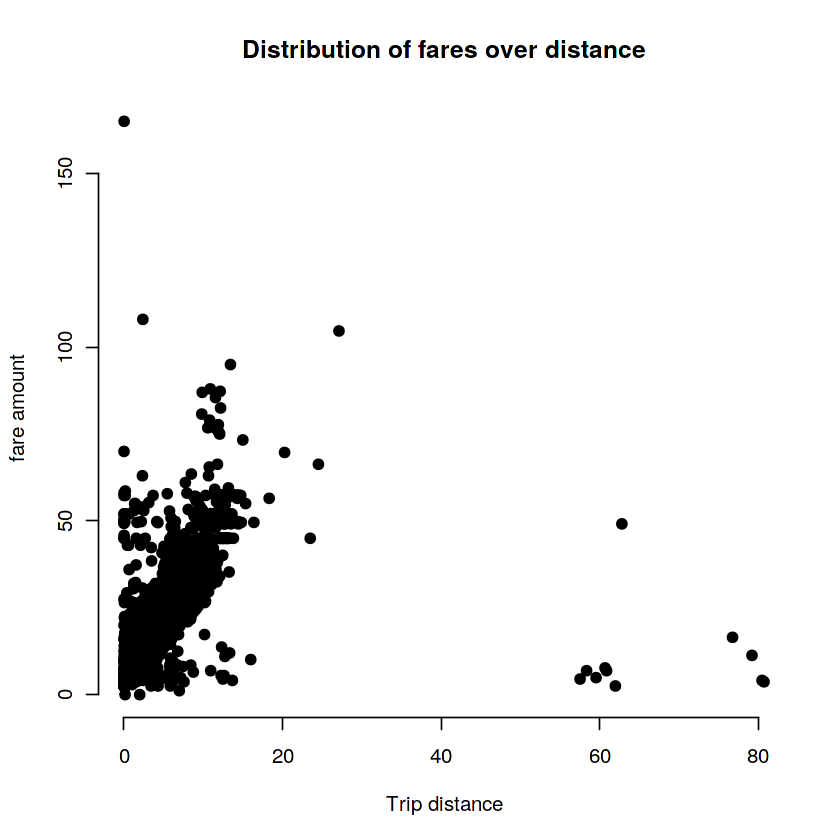

In [637]:
plot(x=df$trip_distance,y=df$fare_amount,main="Distribution of fares over distance",xlab = "Trip distance", ylab = "fare amount",
     pch = 19, frame = FALSE)

**there seems to be a linear relation between the distance travelled and the fare amount. however trips > 50 miles have low prices and constant rates. maybe because normally long trips from airports have fixed prices.**

In [638]:
JFK=list('min_lng'=-73.8352,
     'min_lat'=40.6195,
     'max_lng'=-73.7401, 
     'max_lat'=40.6659)
JFK_center=list(40.6437,-73.7900)


In [ ]:
JFK_data=subset(df, (pickup_latitude >= JFK['min_lat'])& (pickup_latitude <= JFK['max_lat']) &(pickup_longitude >= JFK['min_lng'])& (pickup_longitude <= JFK['max_lng']) ) 

cat("Number of Trips with Pickups from JFK",nrow(JFK_data))

JFK_dropoff=subset(df, (dropoff_latitude >= JFK['min_lat'])& (dropoff_latitude <= JFK['max_lat']) & (dropoff_longitude >= JFK['min_lng'])& (dropoff_longitude <= JFK['max_lng']))

cat("
Number of Trips with Dropoffs to JFK ",nrow(JFK_dropoff))

In [ ]:
cat("mean fare price from JFK airport = ",mean(JFK_data$fare_amount))
cat("
mean fare price from other areas = ",mean(df$fare_amount))

As we can see the mean fare price from JFK airport is 43.30$ which is quite expensive compared to normal price.

**we will create a function which will tell us whether the pickup or drop happened at one of the 3 airports in new york.**

In [639]:
nyc_airports=list('JFK'=list('min_lng'=-73.8352,
     'min_lat'=40.6195,
     'max_lng'=-73.7401, 
     'max_lat'=40.6659),
              
    'EWR'=list('min_lng'=-74.1925,
            'min_lat'=40.6700, 
            'max_lng'=-74.1531, 
            'max_lat'=40.7081

        ),
    'LaGuardia'=list('min_lng'=-73.8895, 
                  'min_lat'=40.7664, 
                  'max_lng'=-73.8550, 
                  'max_lat'=40.7931
        
    )
    
)
isAirport= function(latitude,longitude,airport_name){
    
    ifelse(latitude>=nyc_airports$airport_name$min_lat & latitude<=nyc_airports$airport_name$max_lat & longitude>=nyc_airports$airport_name$min_lng & longitude<=nyc_airports$airport_name$max_lng,"1","0")
       
}

In [640]:
df['is_pickup_JFK']=ifelse(df["pickup_latitude"]>=nyc_airports$JFK$min_lat & df["pickup_latitude"]<=nyc_airports$JFK$max_lat & df["pickup_longitude"]>=nyc_airports$JFK$min_lng & df["pickup_longitude"]<=nyc_airports$JFK$max_lng,as.integer(1),as.integer(0))
df['is_dropoff_JFK']=ifelse(df["dropoff_latitude"]>=nyc_airports$JFK$min_lat & df["dropoff_latitude"]<=nyc_airports$JFK$max_lat & df["dropoff_longitude"]>=nyc_airports$JFK$min_lng & df["dropoff_longitude"]<=nyc_airports$JFK$max_lng,as.integer(1),as.integer(0))
df['is_pickup_EWR']=ifelse(df["pickup_latitude"]>=nyc_airports$EWR$min_lat & df["pickup_latitude"]<=nyc_airports$EWR$max_lat & df["pickup_longitude"]>=nyc_airports$EWR$min_lng & df["pickup_longitude"]<=nyc_airports$EWR$max_lng,as.integer(1),as.integer(0))
df['is_dropoff_EWR']=ifelse(df["dropoff_latitude"]>=nyc_airports$EWR$min_lat & df["dropoff_latitude"]<=nyc_airports$EWR$max_lat & df["dropoff_longitude"]>=nyc_airports$EWR$min_lng & df["dropoff_longitude"]<=nyc_airports$EWR$max_lng,as.integer(1),as.integer(0))
df['is_pickup_la_guardia']=ifelse(df["pickup_latitude"]>=nyc_airports$LaGuardia$min_lat & df["pickup_latitude"]<=nyc_airports$LaGuardia$max_lat & df["pickup_longitude"]>=nyc_airports$LaGuardia$min_lng & df["pickup_longitude"]<=nyc_airports$LaGuardia$max_lng,as.integer(1),as.integer(0))
df['is_dropoff_la_guardia']=ifelse(df["dropoff_latitude"]>=nyc_airports$LaGuardia$min_lat & df["dropoff_latitude"]<=nyc_airports$LaGuardia$max_lat & df["dropoff_longitude"]>=nyc_airports$LaGuardia$min_lng & df["dropoff_longitude"]<=nyc_airports$LaGuardia$max_lng,as.integer(1),as.integer(0))


test1['is_pickup_JFK']=ifelse(test1["pickup_latitude"]>=nyc_airports$JFK$min_lat & test1["pickup_latitude"]<=nyc_airports$JFK$max_lat & test1["pickup_longitude"]>=nyc_airports$JFK$min_lng & test1["pickup_longitude"]<=nyc_airports$JFK$max_lng,as.integer(1),as.integer(0))
test1['is_dropoff_JFK']=ifelse(test1["dropoff_latitude"]>=nyc_airports$JFK$min_lat & test1["dropoff_latitude"]<=nyc_airports$JFK$max_lat & test1["dropoff_longitude"]>=nyc_airports$JFK$min_lng & test1["dropoff_longitude"]<=nyc_airports$JFK$max_lng,as.integer(1),as.integer(0))
test1['is_pickup_EWR']=ifelse(test1["pickup_latitude"]>=nyc_airports$EWR$min_lat & test1["pickup_latitude"]<=nyc_airports$EWR$max_lat & test1["pickup_longitude"]>=nyc_airports$EWR$min_lng & test1["pickup_longitude"]<=nyc_airports$EWR$max_lng,as.integer(1),as.integer(0))
test1['is_dropoff_EWR']=ifelse(test1["dropoff_latitude"]>=nyc_airports$EWR$min_lat & test1["dropoff_latitude"]<=nyc_airports$EWR$max_lat & test1["dropoff_longitude"]>=nyc_airports$EWR$min_lng & test1["dropoff_longitude"]<=nyc_airports$EWR$max_lng,as.integer(1),as.integer(0))
test1['is_pickup_la_guardia']=ifelse(test1["pickup_latitude"]>=nyc_airports$LaGuardia$min_lat & test1["pickup_latitude"]<=nyc_airports$LaGuardia$max_lat & test1["pickup_longitude"]>=nyc_airports$LaGuardia$min_lng & test1["pickup_longitude"]<=nyc_airports$LaGuardia$max_lng,as.integer(1),as.integer(0))
test1['is_dropoff_la_guardia']=ifelse(test1["dropoff_latitude"]>=nyc_airports$LaGuardia$min_lat & test1["dropoff_latitude"]<=nyc_airports$LaGuardia$max_lat & test1["dropoff_longitude"]>=nyc_airports$LaGuardia$min_lng & test1["dropoff_longitude"]<=nyc_airports$LaGuardia$max_lng,as.integer(1),as.integer(0))


**new york has 5 major boroughs. we will create a function and try and find the mean fare price at each of the boroughs.**

In [641]:
 'manhattan'=list(
        'min_lng'=-74.0479,
        'min_lat'=40.6829,
        'max_lng'=-73.9067,
        'max_lat'=40.8820
    )
    
    'queens'=list(
        'min_lng'=-73.9630,
        'min_lat'=40.5431,
        'max_lng'=-73.7004,
        'max_lat'=40.8007
        )

    'brooklyn'=list(
        'min_lng'=-74.0421,
        'min_lat'=40.5707,
        'max_lng'=-73.8334,
        'max_lat'=40.7395

    )

    'bronx'=list(
        'min_lng'=-73.9339,
        'min_lat'=40.7855,
        'max_lng'=-73.7654,
        'max_lat'=40.9176

    )

    'staten_island'=list(
        'min_lng'=-74.2558,
        'min_lat'=40.4960,
        'max_lng'=-74.0522,
        'max_lat'=40.6490

    )
    
    
    


In [642]:
cat("mean ride price in manhattan is : ",mean(subset(df,(dropoff_latitude >= manhattan$min_lat) & (dropoff_latitude <= manhattan$max_lat)&(dropoff_longitude >= manhattan$min_lng)& (dropoff_longitude <= manhattan$max_lng))$fare_amount))
cat("
mean ride price in bronx is : ",mean(subset(df,(dropoff_latitude >= bronx$min_lat) & (dropoff_latitude <= bronx$max_lat)&(dropoff_longitude >= bronx$min_lng)& (dropoff_longitude <= bronx$max_lng))$fare_amount))
cat("
mean ride price in queens is : ",mean(subset(df,(dropoff_latitude >= queens$min_lat) & (dropoff_latitude <= queens$max_lat)&(dropoff_longitude >= queens$min_lng)& (dropoff_longitude <= queens$max_lng))$fare_amount))
cat("
mean ride price in brooklyn is : ",mean(subset(df,(dropoff_latitude >= brooklyn$min_lat) & (dropoff_latitude <= brooklyn$max_lat)&(dropoff_longitude >= brooklyn$min_lng)& (dropoff_longitude <= brooklyn$max_lng))$fare_amount))
cat("
mean ride price in staten island is : ",mean(subset(df,(dropoff_latitude >= staten_island$min_lat) & (dropoff_latitude <= staten_island$max_lat)&(dropoff_longitude >= staten_island$min_lng)& (dropoff_longitude <= staten_island$max_lng))$fare_amount))
                                                             

mean ride price in manhattan is :  10.17721
mean ride price in bronx is :  24.93397
mean ride price in queens is :  14.69174
mean ride price in brooklyn is :  11.69663
mean ride price in staten island is :  27.1

**a cab ride at staten island is most expensive compared to other boroughs. **

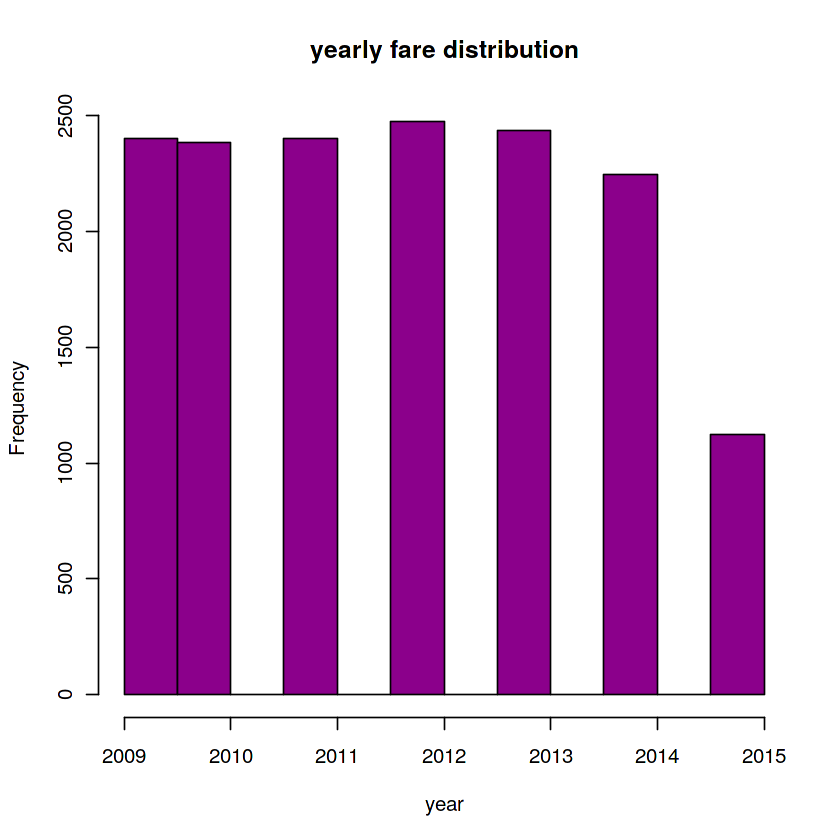

In [643]:
hist(df$year,col="darkmagenta",xlab="year",main="yearly fare distribution")

**from 2009 the demand has been increasing slightly . however in 2015 the demand has gone down drastically compared to other years. the other reason might be that the amount of data provided for this year is less.**

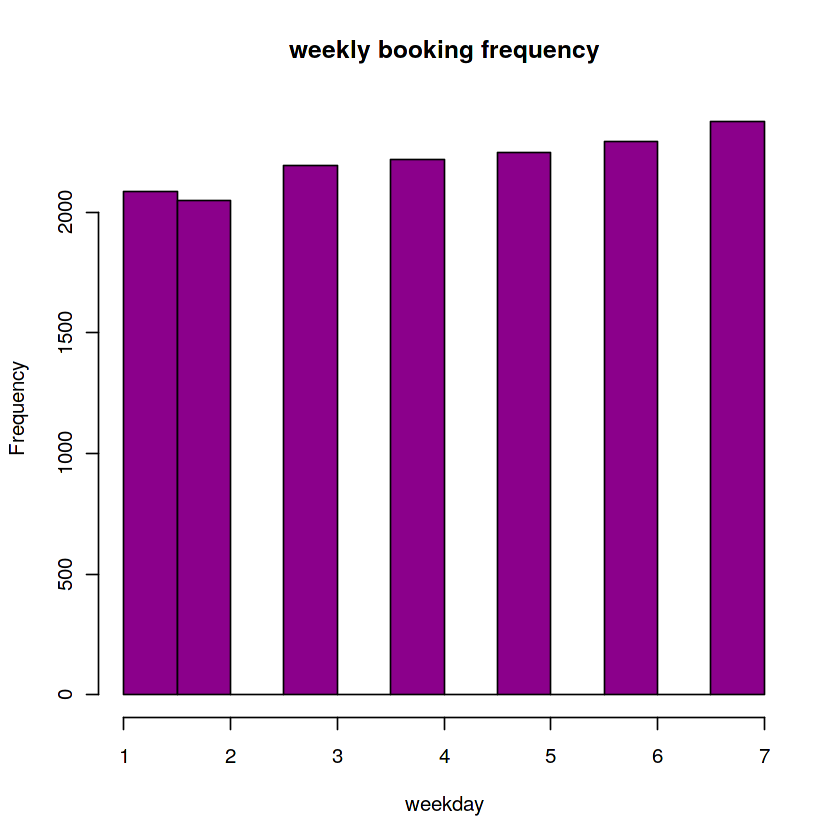

In [644]:
hist(df$weekday,col="darkmagenta",xlab="weekday",main="weekly booking frequency")

**saturdays have the highest demand for cab rides. the demand is slightly less during weekdays.**

**lets check the mean price from an airport vs a normal ride.**

In [647]:
cat("The mean price of normal pickup :", mean(subset(df,(is_pickup_JFK ==0) & (is_pickup_EWR ==0) & (is_pickup_la_guardia ==0))$fare_amount))

cat("
The mean price of airport pickup :", mean(subset(df,(is_pickup_JFK ==1) | (is_pickup_EWR ==1) | (is_pickup_la_guardia ==1))$fare_amount))


The mean price of normal pickup : 10.37906
The mean price of airport pickup : 35.71922

**an airport pickup is expensive as compared to a normal pickup. an airport pickup costs an average of 36 dollars.**

**we will convert the required columns into categories.**

In [648]:
df$is_pickup_JFK=as.factor(df$is_pickup_JFK)
df$is_dropoff_JFK=as.factor(df$is_dropoff_JFK)
df$is_pickup_EWR=as.factor(df$is_pickup_EWR)
df$is_dropoff_EWR=as.factor(df$is_dropoff_EWR)
df$is_pickup_la_guardia=as.factor(df$is_pickup_la_guardia)
df$is_dropoff_la_guardia=as.factor(df$is_dropoff_la_guardia)
df$night=as.factor(df$night)
df$late_night=as.factor(df$late_night)
df$weekday=as.factor(df$weekday)
df$month=as.factor(df$month)

test1$is_pickup_JFK=as.factor(test1$is_pickup_JFK)
test1$is_dropoff_JFK=as.factor(test1$is_dropoff_JFK)
test1$is_pickup_EWR=as.factor(test1$is_pickup_EWR)
test1$is_dropoff_EWR=as.factor(test1$is_dropoff_EWR)
test1$is_pickup_la_guardia=as.factor(test1$is_pickup_la_guardia)
test1$is_dropoff_la_guardia=as.factor(test1$is_dropoff_la_guardia)
test1$night=as.factor(test1$night)
test1$late_night=as.factor(test1$late_night)
test1$weekday=as.factor(test1$weekday)
test1$month=as.factor(test1$month)




In [649]:
x=colnames(select_if(df,is.numeric))

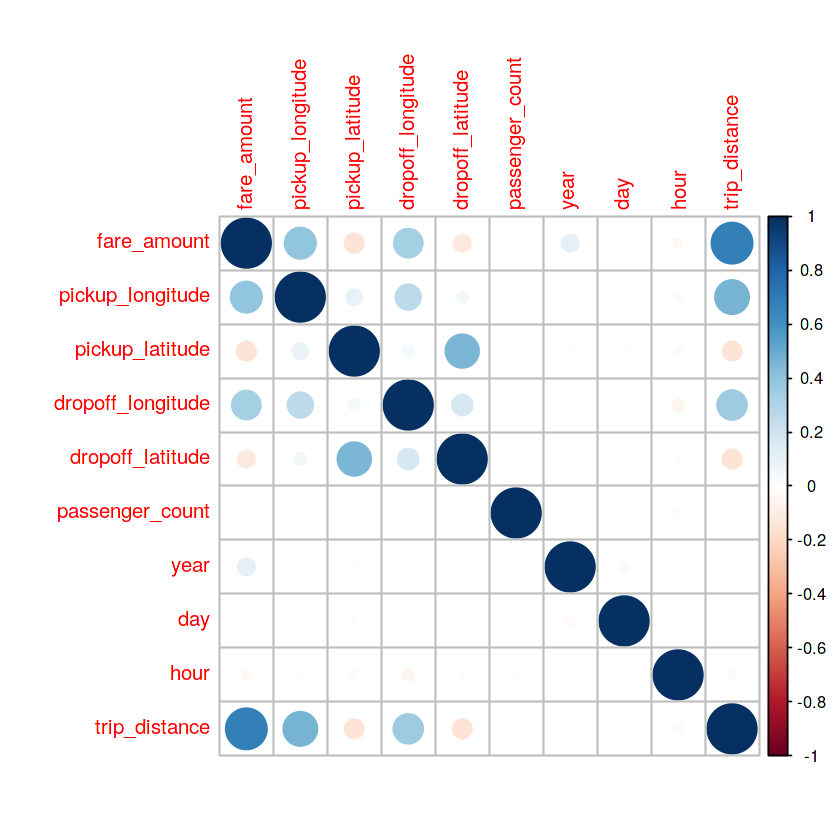

In [650]:
corrplot(cor(df[c(x)]))

**trip distance seems to have a decent impact on the fare price which is logical. there dosent seem to be problem of multicolinearity here.**

**we will normalize the coordinates so as to avoid the model being biased towards some coordinates.**

In [651]:
df["pickup_longitude"]=(df$pickup_longitude-min(df$pickup_longitude))/(max(df$pickup_longitude)-min(df$pickup_longitude))
df["pickup_latitude"]=(df$pickup_latitude-min(df$pickup_latitude))/(max(df$pickup_latitude)-min(df$pickup_latitude))
df["dropoff_longitude"]=(df$dropoff_longitude-min(df$dropoff_longitude))/(max(df$dropoff_longitude)-min(df$dropoff_longitude))
df["dropoff_latitude"]=(df$dropoff_latitude-min(df$dropoff_latitude))/(max(df$dropoff_latitude)-min(df$dropoff_latitude))

test1["pickup_longitude"]=(test1$pickup_longitude-min(test1$pickup_longitude))/(max(test1$pickup_longitude)-min(test1$pickup_longitude))
test1["pickup_latitude"]=(test1$pickup_latitude-min(test1$pickup_latitude))/(max(test1$pickup_latitude)-min(test1$pickup_latitude))
test1["dropoff_longitude"]=(test1$dropoff_longitude-min(test1$dropoff_longitude))/(max(test1$dropoff_longitude)-min(test1$dropoff_longitude))
test1["dropoff_latitude"]=(test1$dropoff_latitude-min(test1$dropoff_latitude))/(max(test1$dropoff_latitude)-min(test1$dropoff_latitude))



# Feature engineering 
 lets use anova test for seeing which variables are significant for our model.***

In [587]:
summary(aov(fare_amount~month,data=df))

               Df  Sum Sq Mean Sq F value  Pr(>F)    
month          11    4600   418.2   4.685 3.4e-07 ***
Residuals   15452 1379272    89.3                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [588]:
summary(aov(fare_amount~weekday,data=df))

               Df  Sum Sq Mean Sq F value Pr(>F)
weekday         6     661  110.21   1.232  0.286
Residuals   15457 1383211   89.49               

In [589]:
summary(aov(fare_amount~late_night,data=df))

               Df  Sum Sq Mean Sq F value Pr(>F)
late_night      1     188  188.30   2.104  0.147
Residuals   15462 1383684   89.49               

weekday and late_night dont have a significant impact on our model. so we will skip these features while training our model.

# Model Building

In [655]:
library(caTools)                              #for train test split


In [656]:
set.seed(125)
split=sample.split(df$fare_amount,SplitRatio = 0.8)
trainset=subset(df,split==TRUE)
testset=subset(df,split==FALSE)
ytest=testset["fare_amount"]


**We will mainly use three models in the process.
1. linear regression
2. decision trees.
3. random forest

**we will compare the models based on error metrics and residual graphs.****

In [657]:
regressor=lm(formula = fare_amount ~pickup_longitude+pickup_longitude+dropoff_longitude+dropoff_latitude+passenger_count+year+month+day+hour+night+trip_distance+is_pickup_JFK+is_dropoff_JFK+is_dropoff_EWR+is_pickup_la_guardia+is_dropoff_la_guardia ,data = trainset)
summary(regressor)



Call:
lm(formula = fare_amount ~ pickup_longitude + pickup_longitude + 
    dropoff_longitude + dropoff_latitude + passenger_count + 
    year + month + day + hour + night + trip_distance + is_pickup_JFK + 
    is_dropoff_JFK + is_dropoff_EWR + is_pickup_la_guardia + 
    is_dropoff_la_guardia, data = trainset)

Residuals:
     Min       1Q   Median       3Q      Max 
-128.765   -2.437   -0.858    1.493  169.725 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -1.114e+03  5.507e+01 -20.235  < 2e-16 ***
pickup_longitude       -6.011e+01  2.716e+00 -22.137  < 2e-16 ***
dropoff_longitude       1.145e+01  2.172e+00   5.271 1.38e-07 ***
dropoff_latitude        1.676e+01  2.675e+00   6.266 3.83e-10 ***
passenger_count         1.138e-02  4.032e-02   0.282   0.7778    
year                    5.609e-01  2.736e-02  20.502  < 2e-16 ***
month2                  4.120e-01  2.454e-01   1.679   0.0932 .  
month3                  4.434e-01  2.37

In [658]:
ypred=predict(regressor,newdata = testset)

In [659]:
m1=lm(ytest$fare_amount ~ ypred)

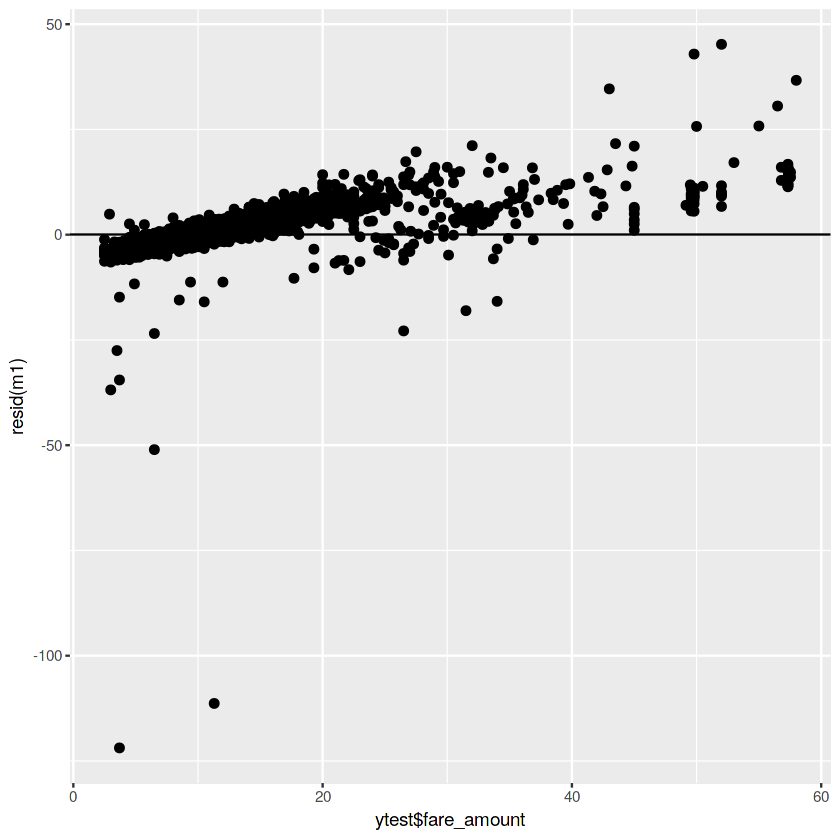

In [661]:
ggplot(data=m1,aes(x=ytest$fare_amount,y=resid(m1)))+geom_point(size=2)+geom_hline(yintercept = 0)   #residual graph of linear model.

as we can see many residual points are not near 0. 

In [662]:
library(Metrics)
cat("mean absolute error : ",mae(ytest$fare_amount,ypred))
cat("
RMSE : ",rmse(ytest$fare_amount,ypred))
cat("
mean absolute percentage error : ",mape(ytest$fare_amount,ypred))
cat("
mean squared error : ",mse(ytest$fare_amount,ypred))

mean absolute error :  2.869715
RMSE :  5.516722
mean absolute percentage error :  0.3429211
mean squared error :  30.43422

In [663]:
library(rpart)
d1=rpart(fare_amount ~pickup_longitude+pickup_longitude+dropoff_longitude+dropoff_latitude+passenger_count+year+month+day+hour+night+trip_distance+is_pickup_JFK+is_dropoff_JFK+is_dropoff_EWR+is_pickup_la_guardia+is_dropoff_la_guardia ,data = trainset,method="anova")
summary(d1)


Call:
rpart(formula = fare_amount ~ pickup_longitude + pickup_longitude + 
    dropoff_longitude + dropoff_latitude + passenger_count + 
    year + month + day + hour + night + trip_distance + is_pickup_JFK + 
    is_dropoff_JFK + is_dropoff_EWR + is_pickup_la_guardia + 
    is_dropoff_la_guardia, data = trainset, method = "anova")
  n= 12409 

          CP nsplit rel error    xerror       xstd
1 0.53409359      0 1.0000000 1.0000362 0.03886030
2 0.08595550      1 0.4659064 0.4672767 0.02737035
3 0.08254364      2 0.3799509 0.3607314 0.02750598
4 0.01552744      3 0.2974073 0.3013373 0.02635734
5 0.01114206      4 0.2818798 0.2861498 0.02669976
6 0.01063941      5 0.2707378 0.2829728 0.02635886
7 0.01037228      6 0.2600984 0.2768910 0.02632159
8 0.01000000      7 0.2497261 0.2716916 0.02625855

Variable importance
        trip_distance      pickup_longitude     dropoff_longitude 
                   54                    13                    12 
        is_pickup_JFK  is_pickup_la_gua

In [664]:
dt_predict=predict(d1,newdata = testset)


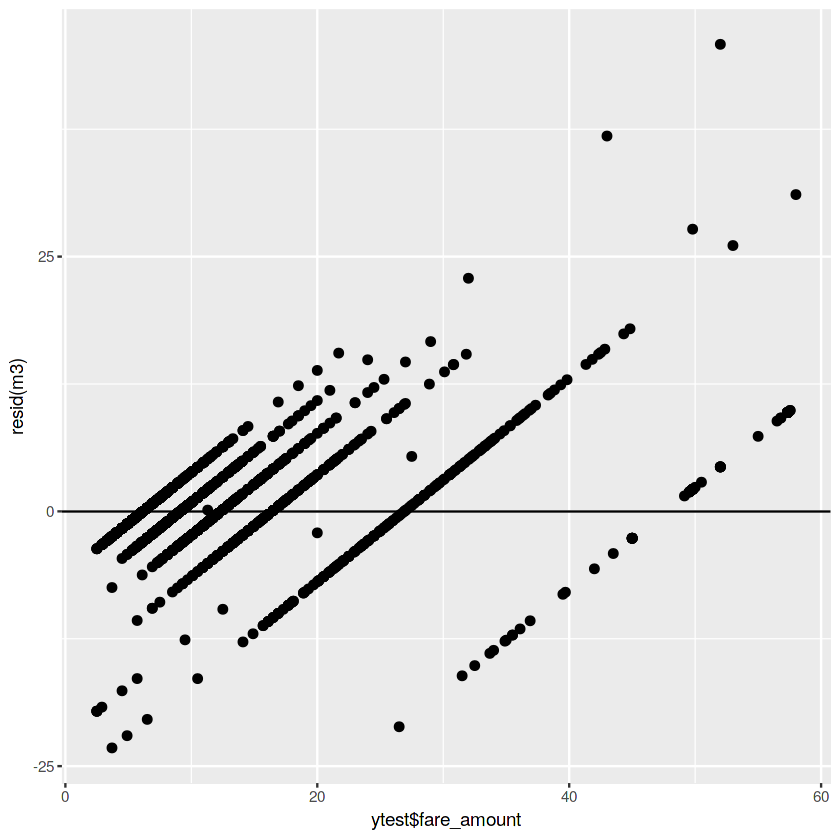

In [665]:
m3=lm(ytest$fare_amount ~ dt_predict)
ggplot(data=m3,aes(x=ytest$fare_amount,y=resid(m3)))+geom_point(size=2)+geom_hline(yintercept = 0)  #residual graph for decision tree
 

In [666]:
cat("mean absolute error : ",mae(ytest$fare_amount,dt_predict))
cat("
RMSE : ",rmse(ytest$fare_amount,dt_predict))
cat("
mean absolute percentage error : ",mape(ytest$fare_amount,dt_predict))
cat("
mean squared error : ",mse(ytest$fare_amount,dt_predict))

mean absolute error :  2.393613
RMSE :  3.821753
mean absolute percentage error :  0.2570742
mean squared error :  14.60579

In [667]:
library(randomForest)
rf=randomForest(formula= fare_amount ~pickup_longitude+pickup_longitude+dropoff_longitude+dropoff_latitude+passenger_count+year+month+day+hour+night+trip_distance+is_pickup_JFK+is_dropoff_JFK+is_dropoff_EWR+is_pickup_la_guardia+is_dropoff_la_guardia ,data = trainset)
summary(rf)

                Length Class  Mode     
call                3  -none- call     
type                1  -none- character
predicted       12409  -none- numeric  
mse               500  -none- numeric  
rsq               500  -none- numeric  
oob.times       12409  -none- numeric  
importance         15  -none- numeric  
importanceSD        0  -none- NULL     
localImportance     0  -none- NULL     
proximity           0  -none- NULL     
ntree               1  -none- numeric  
mtry                1  -none- numeric  
forest             11  -none- list     
coefs               0  -none- NULL     
y               12409  -none- numeric  
test                0  -none- NULL     
inbag               0  -none- NULL     
terms               3  terms  call     

In [668]:
rf_ypred=predict(rf,newdata = testset)

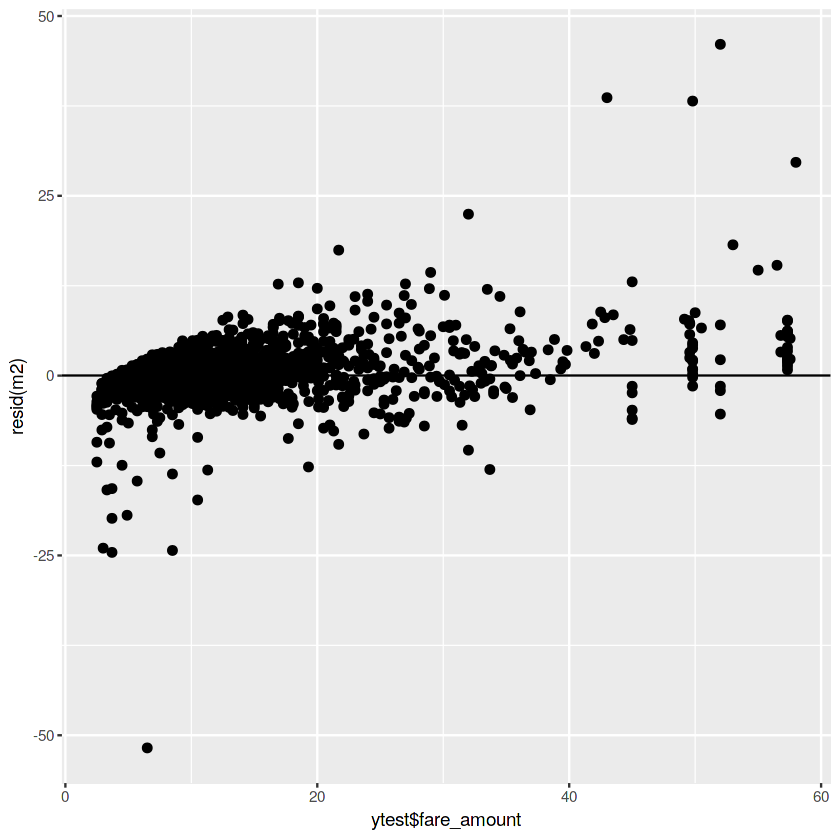

In [669]:
m2=lm(ytest$fare_amount ~ rf_ypred)
ggplot(data=m2,aes(x=ytest$fare_amount,y=resid(m2)))+geom_point(size=2)+geom_hline(yintercept = 0)   # residual graph for random forest

In [670]:
cat("mean absolute error : ",mae(ytest$fare_amount,rf_ypred))
cat("
RMSE : ",rmse(ytest$fare_amount,rf_ypred))
cat("
mean absolute percentage error : ",mape(ytest$fare_amount,rf_ypred))
cat("
mean squared error : ",mse(ytest$fare_amount,rf_ypred))

mean absolute error :  1.856222
RMSE :  3.250605
mean absolute percentage error :  0.2048352
mean squared error :  10.56643

**From the error metrics and residual graphs of the above models it is clearly evident that random forest is performing the best for our dataset. therefore we will use it to predict the fare prices of our test data.**

In [671]:
test1=subset(test1,select =-c(weekday,late_night))

In [672]:
test_result=predict(rf,newdata = test1)